#Dataset Setup:

In [ ]:
source_dir = r'C:\Users\Administrator\Hand_sign_recognition\ASL\asl_alphabet_train'
train_dir = r'C:\Users\Administrator\Hand_sign_recognition\ASL\Train'
test_dir = r'C:\Users\Administrator\Hand_sign_recognition\ASL\Test'

labels = [chr(c) for c in range(65, 91)] + ['space', 'del', 'nothing']  # Fixed list of labels

# Create directories for train and test datasets
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

split_ratio = 0.8

# Split dataset into train and test
for label in labels:
    label_path = os.path.join(source_dir, label)
    
    # Ensure that label directory exists in source_dir
    if not os.path.isdir(label_path):
        print(f"Skipping {label_path} because it doesn't exist.")
        continue
    
    all_files = os.listdir(label_path)
    random.shuffle(all_files)

    split_idx = int(len(all_files) * split_ratio)
    train_files = all_files[:split_idx]
    test_files = all_files[split_idx:]

    # Copy files to train directory
    for file in train_files:
        src_file = os.path.join(label_path, file)
        dst_file = os.path.join(train_dir, label, file)
        
        if os.path.exists(src_file):
            shutil.copy(src_file, dst_file)
        else:
            print(f"Warning: {src_file} does not exist, skipping.")

    # Copy files to test directory
    for file in test_files:
        src_file = os.path.join(label_path, file)
        dst_file = os.path.join(test_dir, label, file)

        if os.path.exists(src_file):
            shutil.copy(src_file, dst_file)
        else:
            print(f"Warning: {src_file} does not exist, skipping.")

print("80/20 split done successfully")

In [5]:
data_path=Path(r"C:\Users\Administrator\Hand_sign_recognition\ASL")
from posixpath import dirname
def walk_by_dir(data_path):
    for dirpath,dirnames,filenames in os.walk(data_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_by_dir(data_path)

There are 2 directories and 0 images in C:\Users\Administrator\Hand_sign_recognition\ASL
There are 3 directories and 0 images in C:\Users\Administrator\Hand_sign_recognition\ASL\Test
There are 0 directories and 600 images in C:\Users\Administrator\Hand_sign_recognition\ASL\Test\A
There are 0 directories and 600 images in C:\Users\Administrator\Hand_sign_recognition\ASL\Test\B
There are 0 directories and 600 images in C:\Users\Administrator\Hand_sign_recognition\ASL\Test\C
There are 3 directories and 0 images in C:\Users\Administrator\Hand_sign_recognition\ASL\Train
There are 0 directories and 2400 images in C:\Users\Administrator\Hand_sign_recognition\ASL\Train\A
There are 0 directories and 2400 images in C:\Users\Administrator\Hand_sign_recognition\ASL\Train\B
There are 0 directories and 2400 images in C:\Users\Administrator\Hand_sign_recognition\ASL\Train\C


##All imports:

In [2]:
import os
import shutil
import torch
import string
import random
import requests
import numpy as np
import pandas as pd
from torch import nn
from pathlib import Path
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from torchvision import datasets,transforms
from sklearn.model_selection import train_test_split

#**Data Agnostic Code:**

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# If CUDA is available, check which GPU is being used
if device:
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


#**Dataset:**

In [7]:
#classic image classification setup:
image_path=data_path
train_dir=image_path / "Train"
test_dir=image_path / "Test"

In [8]:
print(train_dir,test_dir)

C:\Users\Administrator\Hand_sign_recognition\ASL\Train C:\Users\Administrator\Hand_sign_recognition\ASL\Test


#**Visualize...Visualize...Visualize..**

In [9]:
random.seed(42)
#1.Get all the image path:
image_path_list=list(image_path.glob("*/*/*.jpg"))

#2.Getting a random image:
image_random=random.choice(image_path_list)

#3.Getting the image class from the path name:
image_class_name=image_random.parent.stem

#4.Opening the random selected image:
img=Image.open(image_random)

#5.print the metadata:
print(f"Random Image: {image_random}")
print(f"Image Classname: {image_class_name}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")

Random Image: C:\Users\Administrator\Hand_sign_recognition\ASL\Train\A\A1025.jpg
Image Classname: A
Image Height: 200
Image Width: 200


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

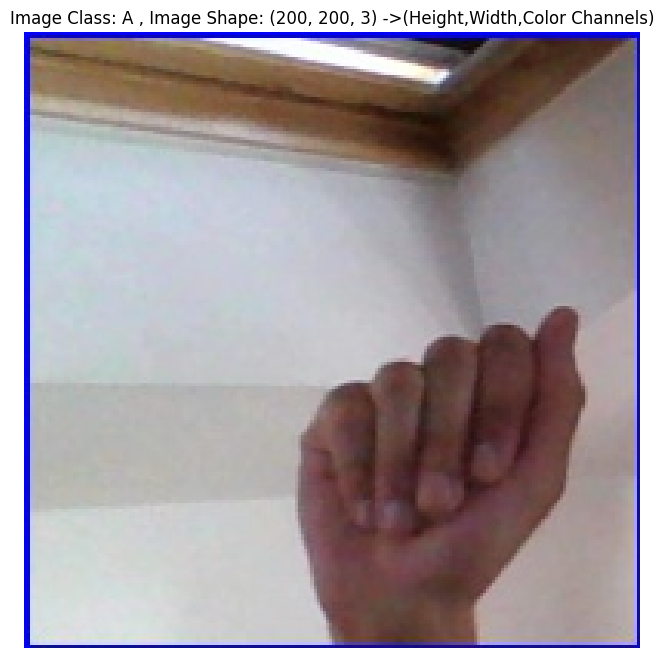

In [10]:
image_array=np.asarray(img)
plt.figure(figsize=(10,8))
plt.imshow(image_array)
plt.title(f"Image Class: {image_class_name} , Image Shape: {image_array.shape} ->(Height,Width,Color Channels)")
plt.axis("off")

#**Turning Images to Tensors:**

In [31]:
Data_transform=transforms.Compose([  ##We can also use nn.Sequential
    #Resizing the image:
    transforms.Resize(size=(64,64)),
    #Fliping the image horizontally randomly:
    transforms.RandomHorizontalFlip(p=0.5),
    #Transforming image to tensor:
    transforms.ToTensor()
])
Data_transform(img)
print(Data_transform(img).shape)
print(Data_transform(img).dtype)

torch.Size([3, 64, 64])
torch.float32


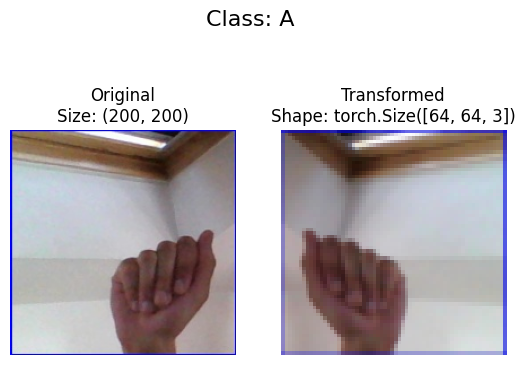

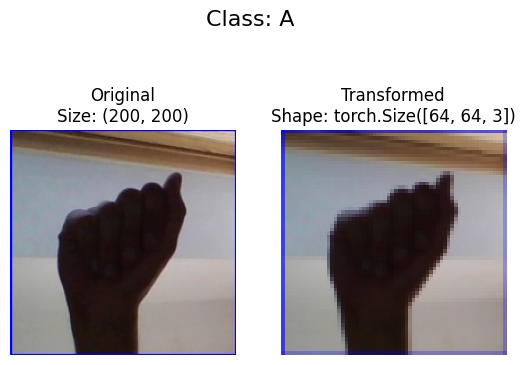

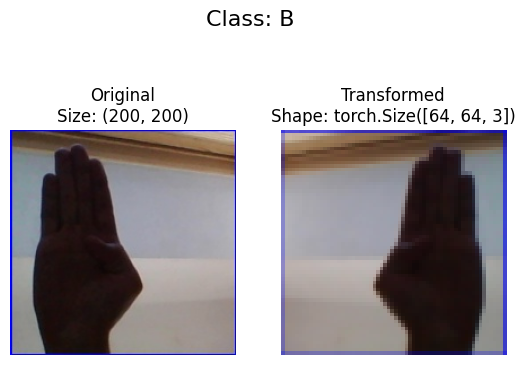

In [32]:
#visualize visualize visualize....
def image_transformer_visualizer(image_paths:list,
                                 transform,
                                 n=3,
                                 seed=None):
  if seed:
    random.seed(seed)
  random_image_path=random.sample(image_paths,k=n)
  for image in random_image_path:
    with Image.open(image) as f:
      fig, ax=plt.subplots(nrows=1,ncols=2)
      #plotting original image:
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis("off")
      #plotting transformed image:
      transformed_image=transform(f).permute(1,2,0) #making change to the shape so as to satisfy matplotlib default image format...(image_channel last)..(C,H,W) to (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      class_name = image.parent.stem
      fig.suptitle(f"Class: {class_name}", fontsize=16)
      plt.show()

image_transformer_visualizer(image_paths=image_path_list,
                             transform=Data_transform,
                             n=3,
                             seed=42)

###Image Folder

In [13]:
###Loading All of our images and Turning them in to tensor With ImageFolder:
###ImageFolder Because we all already following standard image classification Format:
train_data=datasets.ImageFolder(root=train_dir,
                                transform=Data_transform,
                                target_transform=None) #transform for the label
test_data=datasets.ImageFolder(root=test_dir,
                               transform=Data_transform,
                               target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 7200
     Root location: C:\Users\Administrator\Hand_sign_recognition\ASL\Train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1800
     Root location: C:\Users\Administrator\Hand_sign_recognition\ASL\Test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_=train_data.classes
print(class_)
index=train_data.class_to_idx
print(index)

['A', 'B', 'C']
{'A': 0, 'B': 1, 'C': 2}


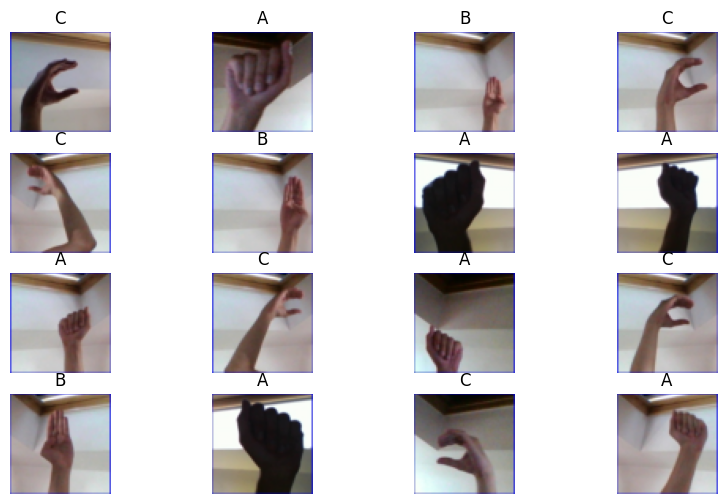

In [15]:
torch.manual_seed(42)
fig=plt.figure(figsize=(10,6))
row,col=4,4
for i in range(1,row*col+1):
  ran_idx=torch.randint(0,len(train_data),size=[1]).item()
  image,label=train_data[ran_idx]
  fig.add_subplot(row,col,i)
  plt.imshow(image.squeeze().permute(1,2,0),cmap="gray")
  plt.title(class_[label])
  plt.axis("off")

In [16]:
images,labels=train_data[0][0],train_data[0][1]
print(f"Image Tensor: {images}")
print(f"Image Shape: {images.shape}")
print(f"Image DataType: {images.dtype}")
print(f"Image Label: {labels}")
print(f"Label Datatype: {type(labels)}")

Image Tensor: tensor([[[0.0510, 0.0941, 0.1020,  ..., 0.3294, 0.3333, 0.2510],
         [0.0980, 0.2314, 0.2392,  ..., 0.7647, 0.7725, 0.5843],
         [0.1255, 0.2706, 0.2627,  ..., 0.7686, 0.7686, 0.5843],
         ...,
         [0.2235, 0.5373, 0.5451,  ..., 0.5843, 0.5765, 0.4392],
         [0.2157, 0.5255, 0.5333,  ..., 0.5725, 0.5647, 0.4392],
         [0.1647, 0.4000, 0.4039,  ..., 0.4353, 0.4314, 0.3333]],

        [[0.0353, 0.0784, 0.0784,  ..., 0.2980, 0.2980, 0.2235],
         [0.0863, 0.1882, 0.1765,  ..., 0.7020, 0.7020, 0.5294],
         [0.0902, 0.2157, 0.2118,  ..., 0.6980, 0.6941, 0.5294],
         ...,
         [0.2275, 0.5412, 0.5490,  ..., 0.5490, 0.5333, 0.3961],
         [0.2314, 0.5451, 0.5490,  ..., 0.5412, 0.5373, 0.3961],
         [0.1765, 0.4157, 0.4196,  ..., 0.4039, 0.4000, 0.3020]],

        [[0.8196, 0.6275, 0.6078,  ..., 0.8235, 0.8196, 0.8588],
         [0.6235, 0.1922, 0.1529,  ..., 0.6588, 0.6706, 0.7373],
         [0.6275, 0.1843, 0.1529,  ..., 0.62

#DataLoader

In [19]:
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=32, 
                            shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=32,
                           shuffle=False)

print("Lenght of Training DataLoader: ",len(train_dataloader))
print("Lenght of Testing DataLoader: ",len(test_dataloader))

Lenght of Training DataLoader:  225
Lenght of Testing DataLoader:  57


#**Helper Function:**

In [18]:
if Path("helper_function.py").is_file():
  print("Already there")
else:
  print("Downloading")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_function.py","wb") as f:
    f.write(request.content)

Already there


#**Model:**

In [41]:
class Model_TinyTGG_CNN(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_unit:int,
                 output_shape: int):
        super().__init__()
        self.conv_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_unit,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                     out_channels=hidden_unit,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.MaxPool2d(stride=2,
                        kernel_size=2)
        )
        self.conv_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit,
                     out_channels=hidden_unit,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                     out_channels=hidden_unit,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.MaxPool2d(stride=2,
                        kernel_size=2)
        )
        self.Classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit*13*13,
                     out_features=output_shape)
        )

    def forward(self,x):
        x=self.conv_1(x)
        #print(x.shape)
        x=self.conv_2(x)
        #print(x.shape)
        x=self.Classifier(x)
        #print(x.shape)

        return x

model_TinyVGG=Model_TinyTGG_CNN(input_shape=3,
                               hidden_unit=20,
                               output_shape=len(class_)).to(device)
model_TinyVGG

Model_TinyTGG_CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3380, out_features=3, bias=True)
  )
)

###Trick to find the input shape:

In [42]:
image_sample,label_sample=next(iter(train_dataloader))
image_sample,label_sample=image_sample.to(device),label_sample.to(device)
model_TinyVGG(image_sample)

tensor([[ 0.0055, -0.0153, -0.0305],
        [ 0.0080, -0.0216, -0.0360],
        [ 0.0123, -0.0247, -0.0362],
        [ 0.0195, -0.0240, -0.0267],
        [ 0.0146, -0.0231, -0.0306],
        [ 0.0068, -0.0172, -0.0299],
        [ 0.0129, -0.0202, -0.0260],
        [ 0.0081, -0.0233, -0.0342],
        [ 0.0096, -0.0145, -0.0305],
        [ 0.0121, -0.0247, -0.0316],
        [ 0.0136, -0.0227, -0.0304],
        [ 0.0093, -0.0190, -0.0278],
        [ 0.0150, -0.0180, -0.0271],
        [ 0.0048, -0.0161, -0.0364],
        [ 0.0107, -0.0245, -0.0363],
        [ 0.0102, -0.0214, -0.0306],
        [ 0.0049, -0.0218, -0.0327],
        [ 0.0073, -0.0207, -0.0337],
        [ 0.0130, -0.0160, -0.0277],
        [ 0.0118, -0.0180, -0.0335],
        [ 0.0115, -0.0243, -0.0349],
        [ 0.0129, -0.0208, -0.0306],
        [ 0.0084, -0.0258, -0.0369],
        [ 0.0121, -0.0230, -0.0328],
        [ 0.0103, -0.0230, -0.0287],
        [ 0.0116, -0.0178, -0.0243],
        [ 0.0139, -0.0192, -0.0314],
 

#**Loss Fuction, Optimizer, Training and Testing Loop:**

In [66]:
def train_step(model_imp:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device):
  model_imp.train()
  train_loss=0
  train_acc=0
  #Add a loop to loop through training the training batches:
  for batch,(X,y) in enumerate(data_loader):
    # Move data to device
    X, y = X.to(device), y.to(device)
    y_pred=model_imp(X)
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #divide the  train_loader  by the len of dataloader.
  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  return train_loss,train_acc

In [67]:
def test_step(model_imp:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device:torch.device):
    model_imp.eval()
    test_loss=0
    test_acc=0
  
    with torch.inference_mode():
        for X,y in data_loader:
      # Move data to device
          X, y = X.to(device), y.to(device)
          test_pred=model_imp(X)
          test_los=loss_fn(test_pred,y)
          test_loss+=test_los.item()

          test_pred_class=test_pred.argmax(dim=1)
          test_acc+=(test_pred_class==y).sum().item()/len(test_pred)

    #calculate the test loss (average):
    test_loss/=len(data_loader)
    test_acc/=len(data_loader)
    return test_loss, test_acc

In [68]:
def print_train_time(start:float,
                     end:float,
                     device:torch.device="None"):
  total_time=end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [69]:
def training(model:torch.nn.Module,
            train_dataloader:torch.utils.data.DataLoader,
            test_dataloader:torch.utils.data.DataLoader,
            optimizer:torch.optim.Optimizer,
            loss_fn:torch.nn.Module=nn.CrossEntropyLoss(),
            epochs=int,
            device=device):
    result={
        "train_loss":[],
        "train_accuracy":[],
        "test_loss":[],
        "test_accuracy":[]
    }
    for epoch in range(epochs):
        train_loss,train_acc=train_step(model_imp=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
        test_loss,test_acc=test_step(model_imp=model,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

        print(f"Epoch : {epoch} | Train Loss: {train_loss:.4f} | Train Accuracy : {train_acc:.4f} | Test Loss : {test_loss:.4f} | Test Accuracy : {test_acc:.4f}")

        result["train_loss"].append(train_loss)
        result["train_accuracy"].append(train_acc)
        result["test_loss"].append(test_loss)
        result["test_accuracy"].append(test_acc)

    return result

In [71]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_TinyVGG.parameters(),
                          lr=0.001)
start_time=timer()
model_result=training(model=model_TinyVGG,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=5,
                     device=device)
end_time=timer()
print(f"Toatal Training Time: {end_time-start_time:.3f} seconds ")

Epoch : 0 | Train Loss: 0.0274 | Train Accuracy : 0.9914 | Test Loss : 0.0895 | Test Accuracy : 0.9748
Epoch : 1 | Train Loss: 0.0161 | Train Accuracy : 0.9950 | Test Loss : 0.0538 | Test Accuracy : 0.9841
Epoch : 2 | Train Loss: 0.0133 | Train Accuracy : 0.9951 | Test Loss : 0.0087 | Test Accuracy : 0.9967
Epoch : 3 | Train Loss: 0.0206 | Train Accuracy : 0.9940 | Test Loss : 0.0159 | Test Accuracy : 0.9945
Epoch : 4 | Train Loss: 0.0103 | Train Accuracy : 0.9961 | Test Loss : 0.0131 | Test Accuracy : 0.9951
Toatal Training Time: 59.551 seconds 


Making Prediction:

In [72]:
def Prediction(model:torch.nn.Module,
               data:list,
              device:torch.device=device):
    pred_probs=[]
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample=torch.unsqueeze(sample,dim=0).to(device)
            y_pred=model(sample)
            pred_prob=torch.softmax(y_pred.squeeze(),dim=0)
            #for prediction it is important for us to make the list from gpu to cpu:
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)   

In [73]:
random.seed(42)
test_samples=[]
test_labels=[]

for sample,label in random.sample(list(test_data),k=45):
    test_samples.append(sample)
    test_labels.append(label)

print(test_samples[0])
print(test_labels[0])

tensor([[[0.0941, 0.2235, 0.2314,  ..., 0.1176, 0.1647, 0.1529],
         [0.2000, 0.4784, 0.5020,  ..., 0.3333, 0.4235, 0.3333],
         [0.2196, 0.4863, 0.4667,  ..., 0.4275, 0.4275, 0.3216],
         ...,
         [0.3451, 0.8392, 0.8471,  ..., 0.6902, 0.7098, 0.5373],
         [0.3373, 0.8275, 0.8314,  ..., 0.6902, 0.7098, 0.5373],
         [0.2588, 0.6275, 0.6275,  ..., 0.5098, 0.5255, 0.3961]],

        [[0.0863, 0.1961, 0.1961,  ..., 0.0863, 0.1333, 0.1294],
         [0.1686, 0.4118, 0.4275,  ..., 0.2667, 0.3765, 0.3176],
         [0.1804, 0.4118, 0.4000,  ..., 0.3922, 0.3961, 0.3020],
         ...,
         [0.3608, 0.8745, 0.8824,  ..., 0.6510, 0.6667, 0.5137],
         [0.3647, 0.8745, 0.8824,  ..., 0.6471, 0.6627, 0.5137],
         [0.2784, 0.6706, 0.6784,  ..., 0.4863, 0.5020, 0.3961]],

        [[0.8549, 0.7020, 0.6824,  ..., 0.6235, 0.6549, 0.7804],
         [0.6902, 0.3373, 0.3176,  ..., 0.2510, 0.3608, 0.5451],
         [0.6745, 0.3020, 0.2627,  ..., 0.3529, 0.3765, 0.

In [75]:
pred_probs=Prediction(model=model_TinyVGG,
                     data=test_samples)
pred_probs[:]

tensor([[1.1126e-14, 2.0922e-24, 1.0000e+00],
        [9.9677e-01, 3.1663e-03, 6.5690e-05],
        [5.7607e-01, 4.2377e-01, 1.6350e-04],
        [4.6212e-05, 5.0657e-12, 9.9995e-01],
        [1.0000e+00, 1.6134e-13, 1.1484e-21],
        [1.0000e+00, 1.8284e-06, 2.4164e-09],
        [1.0000e+00, 1.4571e-17, 8.5698e-15],
        [9.9726e-01, 2.2760e-03, 4.5933e-04],
        [3.3250e-07, 5.3927e-16, 1.0000e+00],
        [1.0000e+00, 1.1391e-06, 4.6250e-07],
        [1.1293e-18, 5.9241e-25, 1.0000e+00],
        [1.6976e-18, 2.9422e-23, 1.0000e+00],
        [1.5352e-03, 9.9846e-01, 1.3582e-06],
        [9.9999e-01, 7.3805e-06, 4.9420e-08],
        [5.2514e-20, 1.1071e-29, 1.0000e+00],
        [2.5593e-02, 9.7441e-01, 2.7228e-11],
        [9.9989e-01, 3.5083e-12, 1.0873e-04],
        [1.0000e+00, 1.2372e-08, 7.1775e-07],
        [9.9999e-01, 8.4842e-06, 1.6460e-06],
        [1.0000e+00, 2.9592e-10, 5.4844e-13],
        [1.0000e+00, 3.4298e-08, 2.3690e-12],
        [5.4926e-07, 1.0000e+00, 3

In [76]:
test_labels=torch.tensor(test_labels)
test_labels

tensor([2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0,
        1, 0, 2, 2, 2, 1, 0, 1, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 1, 0, 0])

In [77]:
pred_proba=pred_probs.argmax(dim=1)
pred_proba

tensor([2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0,
        1, 0, 2, 2, 2, 1, 0, 1, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 1, 0, 0])

In [ ]:
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i,sample in enumerate(test_samples):
    plt.subplot(nrows,ncols,i+1)
    if sample.shape[0]==1:
        img=sample.squeeze()
        cmap="gray"
    elif sample.shape[0]==3:
        img=sample.permute(1,2,0)
        cmap=None
    else:
        raise ValueError(f"Invalid Shape:{sample.shape}")
    plt.imshow(img,cmap=cmap)
    pred_label=class_[pred_proba[i]]
    true_label=class_[test_labels[i]]
    title_text=f"Prediction: {pred_label} | Truth: {true_label}"

    if pred_label==true_label:
        plt.title(title_text,fontsize=9,c='g')
        plt.axis("off")
    else:
        plt.title(title_text,fontsize=9,c='r')
        plt.axis("off")
plt.tight_layout()
plt.show()